# **LSTM Notebook**
<br> **Assignment**: W266 NLP Final Project
<br> **Team**: Sydney Lister, Lucy Herr, Torrey Trahanovsky
<br> **Class:** UCB MIDS w266 Natural Language Processing
<br> **Term:** Spring 2024

<br>
<br>
<br>

---

# Imports and Environment Vars

In [ ]:
# !pip install keras-tuner --quiet

In [27]:
import os

import json
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import itertools

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import fbeta_score, precision_score, recall_score,classification_report,confusion_matrix


In [28]:
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [29]:
BATCH_SIZE = 16
MAX_SEQ_LEN = 512
WORD_INDEX_FOR_PADDING = -100
PII = ["B-NAME_STUDENT", "B-USERNAME", "I-NAME_STUDENT","O"]

In [30]:
# test for tf.dtype consistency
# from tensorflow.keras.mixed_precision import set_global_policy
# set_global_policy('mixed_float16')

In [31]:
# test eager v. lazy eval for lstm runtime
tf.config.run_functions_eagerly(True)

In [32]:
import keras
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, Flatten
from tensorflow.keras.layers import InputLayer, TimeDistributed, SpatialDropout1D, Bidirectional

# from tensorflow import keras

In [33]:
print('Tensorflow version:', tf.__version__) # 2.15.0
print('GPU detected:', tf.config.list_physical_devices('GPU')) # GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Tensorflow version: 2.15.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<br>
<br>
<br>

---


# Data Loading & Preprocessing

In [61]:
BASE_PATH = "/content/drive/MyDrive/266/266 Final Project Team/kaggle_data"
#BASE_PATH = "/content/drive/MyDrive/MIDS_W266_DATA"

In [17]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [18]:
data = pd.read_json(f"{BASE_PATH}/train.json")

In [35]:
def clean_df(data):
  doc_index = []
  tokens = []
  labels = []
  docs = []
  token_index = []
  for index, row in data.iterrows():
    document = row['full_text']
    for i, (tok, lab) in enumerate(zip(row['tokens'], row['labels'])):
      doc_index.append(index)
      tokens.append(tok)
      labels.append(lab)
      token_index.append(i)
      docs.append(document)

  return pd.DataFrame({"doc": docs, "doc_index": doc_index, "word": tokens, "label": labels, "word_index": token_index})

df = clean_df(data)
full_texts = df.doc.unique()

In [40]:
# tf mapping
words = list(set(df["word"].values))
words2idx = {w: i for i, w in enumerate(words)}
words.append("ENDPAD")
num_words = len(words)

tags = PII
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for i, t in enumerate(tags)}
num_tags = len(PII)

In [41]:
# get_doc_word_label_pairs creates a list for each document where each item is a list of tuples (word, label)
# also ensures that each label in the tuples are contained within the valid list of PII to identify, otherwise marked with label 'O'
def get_doc_word_label_pairs(data):
  agg_func = lambda d: [(w,l) if l in tags else (w, 'O') for w, l in zip(d["word"].values.tolist(),
                                                           d["label"].values.tolist())]
  return df.groupby('doc_index').apply(agg_func).tolist()

doc_word_label_pairs=get_doc_word_label_pairs(df)

In [49]:
def get_doc_word_label_arrays(data):
  # map tuples (w,t) to arrays
  agg_func_word = lambda d: [str(w) for w in d["word"].values.tolist()]
  agg_func_token = lambda d: [str(t) if t in tags else "O" for t in d["label"].values.tolist()]
  return data.groupby('doc_index').apply(agg_func_word).tolist(), data.groupby('doc_index').apply(agg_func_token).tolist()

doc_word_label_arrays=get_doc_word_label_arrays(df)

In [51]:
# seq padding
word2idx = {w: i + 1 for i, w in enumerate(words)}

X = [[word2idx[w[0]] for w in d] for d in doc_word_label_pairs]
X = pad_sequences(maxlen=MAX_SEQ_LEN, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in d] for d in doc_word_label_pairs]
y = pad_sequences(maxlen=MAX_SEQ_LEN, sequences=y, padding="post", value=tag2idx["O"])

In [46]:
# split preprocessed arrays 80/20
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

<br>
<br>
<br>

---


# Evaluation


In [53]:
classes = np.unique(np.ravel(y_train,order='C'))
weights = compute_class_weight('balanced',
                                     classes=np.unique(np.ravel(y_train,order='C')),
                                     y=np.ravel(y_train,order='C'))
class_weights = dict(zip(classes, weights)) # {
weights = [class_weights[k] for k in sorted(class_weights.keys())] # inv. weight vals (int)

In [52]:
def generate_class_report(true_labels, predicted_labels,
                          LABELS=[0,1,2,3],
                          TARGET_NAMES=PII):
  # true_labels' & 'predicted_labels: arrays of shape (n_samples,) or (n_samples, n_outputs)
  if isinstance(true_labels, np.ndarray):
    true_labels = true_labels.flatten()
  if isinstance(predicted_labels, np.ndarray):
    predicted_labels = predicted_labels.flatten()
  report = classification_report(true_labels, predicted_labels,
                                 labels=LABELS,
                                 target_names=TARGET_NAMES,
                                 zero_division=0.0) # default='warn'
  print(report)

In [56]:
def plot_confusion_matrix_v2(y_true, y_pred,
                             classes=PII,
                             normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Label')
    plt.xlabel('Prediction')
    plt.figure()
    plt.show()

# # class_names = ['B-NAME_STUDENT', 'B-USERNAME', 'I-NAME_STUDENT', 'O']

In [ ]:
#!pip install tensorflow-addons --quiet

In [ ]:
# weighted f1 score to address class imbalance
# import tensorflow_addons as tfa

# weighted_f1 = tfa.metrics.F1Score(num_classes=4, average='weighted')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning:



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 




<br>
<br>
<br>

---

# Base LSTM

In [ ]:
# build base lstm model

def build_LSTM_base(batch_size, metrics=['accuracy',weighted_f1], learning_rate = 0.05):
  model = keras.Sequential()
  model.add(InputLayer(input_shape=(MAX_SEQ_LEN,), batch_size = batch_size))
  model.add(Embedding(input_dim=num_words,
                      output_dim=MAX_SEQ_LEN,
                      input_length=MAX_SEQ_LEN))
  model.add(SpatialDropout1D(0.1))
  model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))

  model.add(Dense(units=num_tags, activation='softmax'))

  #model summary
  model.summary()

  #show model plot
  tf.keras.utils.plot_model(
      model, to_file='model.png', show_shapes=True, show_dtype=True,
      show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
  )

  #compile model
  model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=cf_cxe_loss,
                metrics=[metrics])
  return model

TypeError: Missing required positional argument

In [ ]:
model = build_LSTM_base(batch_size=BATCH_SIZE,metrics=['accuracy'])

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (16, 512, 512)            27640832  
                                                                 
 spatial_dropout1d_42 (Spat  (16, 512, 512)            0         
 ialDropout1D)                                                   
                                                                 
 bidirectional_42 (Bidirect  (16, 512, 200)            490400    
 ional)                                                          
                                                                 
 dense_43 (Dense)            (16, 512, 4)              804       
                                                                 
Total params: 28132036 (107.32 MB)
Trainable params: 28132036 (107.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


TypeError: Missing required positional argument

In [57]:
# fit base model & plot loss
hist = model.fit(x=x_train,
                 y=y_train,
                 validation_data=(x_test, y_test),
                 epochs=6,
                 callbacks=[callback]
                 verbose=1)

plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

SyntaxError: invalid syntax (<ipython-input-57-d1455b3dae9c>, line 1)

## LSTM Hyperparameter Tuning

In [21]:
def build_model(hp):
    model = keras.Sequential()
    model.add(InputLayer(input_shape=(MAX_SEQ_LEN,)))
    model.add(Embedding(input_dim=num_words, output_dim=hp.Int('output_dim', min_value=32, max_value=512, step=32),
                        input_length=MAX_SEQ_LEN))
    model.add(SpatialDropout1D(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05)))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                                 return_sequences=True, recurrent_dropout=hp.Float('recurrent_dropout', 0.0, 0.5, step=0.1))))

    model.add(Dense(units=num_tags, activation='softmax'))

    model.compile(tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy']) # USE ALTERNATIVE TO ACCURACY?

    return model

In [ ]:
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy', # USE ALTERNATIVE TO ACCURACY?
                     max_epochs=10,
                     factor=3)
                    #  directory='my_dir',
                    #  project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# save optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

## Weighted tf loss version - tested but not yet working


In [ ]:
#weights = [class_weights[k] for k in sorted(class_weights.keys())]

# def weighted_cross_entropy(y_true, y_pred): #,batch_size=BATCH_SIZE,dim_classes=num_tags):
#   # # cast ytrue/ypred as float and convert to tensor
#   # y_true = tf.cast(y_true, tf.float32)
#   # y_pred = tf.cast(y_pred, tf.float32)
#   weights = tf.constant([0.0, 1.0, 2.0, 3.0], dtype=y_pred.dtype)
#   weights = tf.reshape(weights, [1, 1, -1])
#   # scale predictions to ensure class probs for sample sum to 1
#   y_pred /= tf.reduce_sum(y_pred, axis=-1, keepdims=True)
#    # clip pred to prevent log(0) error
#   y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
#   # y_true = tf.cast(y_true, dtype=y_pred.dtype)
#   y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_tags)
#   # cxe loss computation
#   loss = -y_true * tf.math.log(y_pred)
#   loss = loss * weights  # Broadcasting weights correctl
#   return tf.reduce_mean(loss, axis=-1) # mean over ALL classes

In [ ]:
# tf.keras.losses.categorical_focal_crossentropy(
#     y_true,
#     y_pred,
#     alpha=0.25,
#     gamma=2.0,
#     from_logits=False,
#     label_smoothing=0.0,
#     axis=-1
# )

# Calling with 'sample_weight'.
# scce(y_true, y_pred, sample_weight=np.array([0.3, 0.7]))

# from tensorflow.keras.losses import categorical_focal_crossentropy
#cf_cxe_loss = tf.keras.losses.categorical_focal_crossentropy(alpha=0.25)


In [ ]:
# import tensorflow as tf
# from itertools import product

# def w_categorical_crossentropy(y_true, y_pred):
#   weights = tf.constant([0.0, 1.0, 2.0, 3.0], dtype=y_pred.dtype)
#   print(weights.shape)#(4,)

#   weights = tf.reshape(weights, [1, 1, -1])
#   print(weights.shape) # (1, 1, 4)

#   print(y_pred.shape) #(None, 512, 4)
#   print(y_true.shape) # (None, 512)

#   cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False)
#   print(cross_entropy.shape)

#   pred_max_indices = tf.argmax(y_pred, axis=-1) # (None, 512)
#   print(pred_max_indices.shape)

#   gather_indices = tf.stack([tf.range(tf.shape(y_true)[0]), pred_max_indices], axis=1)
#   print(gather_indices.shape)

#   selected_weights = tf.gather_nd(weights, gather_indices)
#   print(selected_weights.shape)

#   weighted_loss = cross_entropy * selected_weights
#   return weighted_loss

In [ ]:
# loss_object = tf.losses.CategoricalCrossentropy()

# def compute_loss(model, x, y, training):
#   out = model(inputs=x, training=training)
#   sample_weight = tf.random.uniform((tf.shape(x)[0], 1),
#                                     minval=0,
#                                     maxval=1,
#                                     dtype=tf.float32)
#   loss = loss_object(y_true=y, y_pred=out, sample_weight=sample_weight)
#   return loss

In [ ]:
# @title
# def multi_class_fbeta(ytrue , ypred, beta=5.0, average='micro', epsilon=1e-7):
#     # epsilon is set to avoid division by zero error
#     beta_squared = beta**2
#     ytrue = tf.one_hot(tf.cast(ytrue, tf.int32), num_tags)

#     # casting ytrue and ypred as floats
#     ytrue = tf.cast(ytrue, tf.float32)
#     ypred= tf.cast(ypred, tf.float32)

#     # finding the maximum probability in ypred
#     max_prob = tf.reduce_max(ypred, axis=-1, keepdims=True)

#     # making ypred one hot encoded such that the class with the maximum probability as encoded as 1 while others as 0
#     ypred = tf.cast(tf.equal(ypred, max_prob), tf.float32)

#     tp = tf.reduce_sum(ytrue*ypred, axis=0) # calculating true positives
#     predicted_positive = tf.reduce_sum(ypred, axis=0) # calculating predicted positives
#     actual_positive = tf.reduce_sum(ytrue, axis=0) # calculating actual positives

#     # calculating precision and recall
#     precision = tp/(predicted_positive+epsilon)
#     recall = tp/(actual_positive+epsilon)

#     # finding fbeta
#     fb = (1+beta_squared)*precision*recall / (beta_squared*precision + recall + epsilon)

#     if average == 'weighted':
#       supports = tf.reduce_sum(ytrue, axis=0)
#       return tf.reduce_sum(fb*supports / tf.reduce_sum(supports))

#     elif average == 'raw': # raw returns the fbeta scores without aggregating them
#       return fb

#     return tf.reduce_mean(fb)

In [ ]:
# @title
# class StatefullMultiClassFBeta(keras.metrics.Metric):
#   def __init__(self, name='fbeta_score', beta=5.0, n_class=num_tags, average='micro', epsilon=1e-7, **kwargs):
#     # initializing an object of the super class
#     super(StatefullMultiClassFBeta, self).__init__(name=name, **kwargs)

#     # initializing state variables
#     self.tp = self.add_weight(name='tp', shape=(MAX_SEQ_LEN,n_class), initializer='zeros')     # initializing true positives
#     self.actual_positives = self.add_weight(name='ap', shape=(MAX_SEQ_LEN,n_class), initializer='zeros') # initializing actual positives
#     self.predicted_positives = self.add_weight(name='pp', shape=(MAX_SEQ_LEN,n_class), initializer='zeros') # initializing predicted positives

#     # initializing other atrributes that wouldn't be changed for every object of this class
#     self.beta_squared = beta**2
#     self.n_class = n_class
#     self.average = average
#     self.epsilon = epsilon

#   def update_state(self, ytrue, ypred, sample_weight=None):
#     ytrue = tf.one_hot(ytrue, num_tags)
#     # casting ytrue and ypred as float dtype
#     ytrue = tf.cast(ytrue, tf.float32)
#     ypred = tf.cast(ypred, tf.float32)
#     # finding the maximum probability in ypred
#     max_prob = tf.reduce_max(ypred, axis=-1, keepdims=True)

#     # making ypred one hot encoded such that the class with the maximum probability as encoded as 1 while others as 0
#     ypred = tf.cast(tf.equal(ypred, max_prob), tf.float32)

#     self.tp.assign_add(tf.reduce_sum(ytrue*ypred, axis=0)) # updating true positives atrribute
#     self.predicted_positives.assign_add(tf.reduce_sum(ypred, axis=0)) # updating predicted positives atrribute
#     self.actual_positives.assign_add(tf.reduce_sum(ytrue, axis=0)) # updating actual positives atrribute

#   def result(self):
#     self.precision = self.tp/(self.predicted_positives+self.epsilon) # calculates precision
#     self.recall = self.tp/(self.actual_positives+self.epsilon) # calculates recall

#     # calculating fbeta score
#     self.fb = (1+self.beta_squared)*self.precision*self.recall / (self.beta_squared*self.precision + self.recall + self.epsilon)

#     if self.average == 'weighted':
#       return tf.reduce_sum(self.fb*self.actual_positives / tf.reduce_sum(self.actual_positives))

#     elif self.average == 'raw':
#       return self.fb

#     return tf.reduce_mean(self.fb)

#   def reset_states(self):
#     self.tp.assign(tf.zeros(self.n_class)) # resets true positives to zero
#     self.predicted_positives.assign(tf.zeros(self.n_class)) # resets predicted positives to zero
#     self.actual_positives.assign(tf.zeros(self.n_class)) # resets actual positives to zero

In [ ]:
# class weigts
tag2idx = {t: i for i, t in enumerate(tags)}
weights2tag = {i: w for i, w in enumerate(weights)}
weights2tag

{0: 1479.7452229299363,
 1: 232320.0,
 2: 2226.709265175719,
 3: 0.25007059428005135}

(document index, token index , token, true label, predicted label)

In [63]:
#hypermodel = tuner.hypermodel.build(best_hps)

In [ ]:
def build_LSTM_tuned(batch_size, metrics='f1', learning_rate = 0.003):
  model = keras.Sequential()
  model.add(InputLayer(input_shape=(MAX_SEQ_LEN,), batch_size = batch_size))
  model.add(Embedding(input_dim=num_words,
                      output_dim=MAX_SEQ_LEN,
                      input_length=MAX_SEQ_LEN))
  model.add(SpatialDropout1D(0.3))
  model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.2)))

  model.add(Dense(units=num_tags, activation='softmax'))

  #model summary
  model.summary()

  #show model plot
  tf.keras.utils.plot_model(
      model, to_file='model.png', show_shapes=True, show_dtype=True,
      show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
  )

  #compile model
  model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=[metrics])
  return model

tuned_lstm = build_LSTM_tuned(BATCH_SIZE, metrics=multi_class_fbeta)

hist = tuned_lstm.fit(x=x_train,
                      y=y_train,
                      validation_data=(x_test, y_test),
                      epochs=4,
                      verbose=1)

# plot loss
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (16, 512, 512)            27640832  
                                                                 
 spatial_dropout1d_1 (Spati  (16, 512, 512)            0         
 alDropout1D)                                                    
                                                                 
 bidirectional_1 (Bidirecti  (16, 512, 200)            490400    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (16, 512, 4)              804       
                                                                 
Total params: 28132036 (107.32 MB)
Trainable params: 28132036 (107.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/4


KeyboardInterrupt: 

## Add CRF Layer

In [ ]:
!pip install keras_crf --quiet

In [ ]:
from keras_crf import CRFModel

def build_LSTM_tuned_crf_2(batch_size, metrics='accuracy', learning_rate = 0.003):
  model = keras.Sequential()
  model.add(InputLayer(input_shape=(MAX_SEQ_LEN,), batch_size = batch_size))
  model.add(Embedding(input_dim=num_words,
                      output_dim=MAX_SEQ_LEN,
                      input_length=MAX_SEQ_LEN))
  model.add(SpatialDropout1D(0.3))
  model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.2)))

  model.add(Dense(units=num_tags))
  # build CRFModel, 5 is num of tags
  crf_model = CRFModel(model, 4)

  #compile model
  crf_model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=[metrics])
  return crf_model


tuned_lstm_crf = build_LSTM_tuned_crf_2(BATCH_SIZE, metrics='accuracy')

tuned_lstm_crf.summary()

Model: "crf_model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_44 (InputLayer)       [(16, 512)]                  0         []                            
                                                                                                  
 embedding_43 (Embedding)    (16, 512, 512)               2764083   ['input_44[0][0]']            
                                                          2                                       
                                                                                                  
 spatial_dropout1d_43 (Spat  (16, 512, 512)               0         ['embedding_43[0][0]']        
 ialDropout1D)                                                                                    
                                                                                        

Epoch 1/4


    with tf.GradientTape() as tape:
      loss = loss_fn()
      scaled_loss = opt.get_scaled_loss(loss)
    scaled_grads = tape.gradient(scaled_loss, vars)
    grads = opt.get_unscaled_gradients(scaled_grads)
    opt.apply_gradients([(grads, var)])
For more information, see https://www.tensorflow.org/api_docs/python/tf/tf_keras/mixed_precision/LossScaleOptimizer
    with tf.GradientTape() as tape:
      loss = loss_fn()
      scaled_loss = opt.get_scaled_loss(loss)
    scaled_grads = tape.gradient(scaled_loss, vars)
    grads = opt.get_unscaled_gradients(scaled_grads)
    opt.apply_gradients([(grads, var)])
For more information, see https://www.tensorflow.org/api_docs/python/tf/tf_keras/mixed_precision/LossScaleOptimizer


171/171 [==============================] - 874s 5s/step - decode_sequence_accuracy: 0.9960 - loss: 229.6318 - val_decode_sequence_accuracy: 0.9997 - val_loss: -66.2500
Epoch 2/4
171/171 [==============================] - 702s 4s/step - decode_sequence_accuracy: 0.9997 - loss: 394.9666 - val_decode_sequence_accuracy: 0.9997 - val_loss: 503.5000
Epoch 3/4
171/171 [==============================] - 703s 4s/step - decode_sequence_accuracy: 0.9997 - loss: -153.8594 - val_decode_sequence_accuracy: 0.9997 - val_loss: -504.2500
Epoch 4/4
171/171 [==============================] - 693s 4s/step - decode_sequence_accuracy: 0.9997 - loss: -296.4462 - val_decode_sequence_accuracy: 0.9998 - val_loss: -83.1250


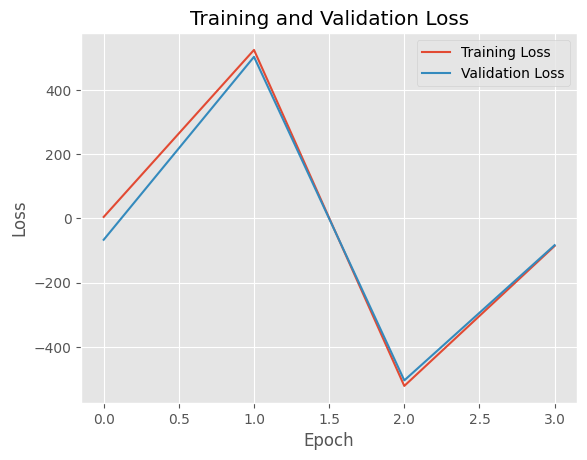

In [ ]:
hist = tuned_lstm_crf.fit(x=x_train,
                      y=y_train,
                      validation_data=(x_test, y_test),
                      epochs=4,
                      verbose=1)

# plot loss
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# @title
# training
# tfa.text.crf_log_likelihood(
#     inputs, # [batch_size, max_seq_len, num_tags]
#     tag_indices,# [batch_size, max_seq_len]
#     sequence_lengths, # [batch_size] vector of true sequence lengths
#     transition_params=None # [num_tags, num_tags] transition matrix, if available.
# )

In [ ]:
# https://medium.com/analytics-vidhya/named-entity-recognition-using-deep-learning-elmo-embedding-bi-lstm-48295bc66cab#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjkzYjQ5NTE2MmFmMGM4N2NjN2E1MTY4NjI5NDA5NzA0MGRhZjNiNDMiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMDcyNzYzMzk4OTM2NTYxMDQ1NjAiLCJlbWFpbCI6Imx1Y3ltb2ZmaXR0aGVyckBnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwibmJmIjoxNzEyNDE3Mzc3LCJuYW1lIjoiTHVjeSBIZXJyIiwicGljdHVyZSI6Imh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hL0FDZzhvY0lEeTAwOV9ieUhCZlZZOUZ1dlZwaU9lbENWOW5HaExSRkkxbHlqTWdWZGhlQWRLSE8yPXM5Ni1jIiwiZ2l2ZW5fbmFtZSI6Ikx1Y3kiLCJmYW1pbHlfbmFtZSI6IkhlcnIiLCJpYXQiOjE3MTI0MTc2NzcsImV4cCI6MTcxMjQyMTI3NywianRpIjoiYWM0YTNlYjFlNDI5MGM5YzUxMmU5ZmM5OWMxNTVlZGIwNGJjNTY4OSJ9.Lo-lZJl9WGw2g-LV-hWbPYY0ndsKTfelgZsPsoU-NM9GidAKVDrABO6altjoT753vbJT0SNS6cfO3dcB6JQ0JWQOReXiOvTTZ03_5TLD5hFf_v2zlhMlvqNL43HWWItvo2HboPjiAFqaUkyVh9Vl0x8thjEnIKMCnKBWIx6AOAUZZzbn6iOxM2PHbbgiT8BJ2h567TfnzYre4jactxyNMQhH91m_PSBLI2zRPSadMQPjOqGXg1F52XHhbpq89jXi1Ccz5GvijqwI5rc4bAPlVu0BUonDZaW90lNvz4NKAqQT4vamrsmfu44twiNopkCCCtHjrzXOpM7JekoQlhHVXg

# output = ner_model.predict(sample_input)
# prediction = np.argmax(output, axis=-1)[0]
# prediction = [mapping[i] for i in prediction]
# # eu -> B-ORG, german -> B-MISC, british -> B-MISC
# print(prediction)

# OUR MAPPING:
# tags = PII
# tag2idx = {t: i for i, t in enumerate(tags)}
# idx2tag = {i: t for i, t in enumerate(tags)}

# num_tags = len(PII)

#y = pad_sequences(maxlen=MAX_SEQ_LEN, sequences=y, padding="post", value=tag2idx["O"])


# def convert_preds_to_tags(pred):
#   out = []
#   for pred_i in pred:
#     out_i = []
#     for p in pred_i:
#       p_1 = np.argmax(p)
#       out_i.append(idx2tag[p_i].replace('PADword','O'))#?
#     out.append(out_i)
#   return out

# def convert_test_to_tags(pred):
#   out = []
#   for pred_i in pred:
#     out_i = []
#     for p in pred_i:
#       p = np.argmax(p)
#       out_i.append(idx2tag[p].replace('PADword','O')) #?
#     out.append(out_i)
#   return out

# pred_tags = convert_preds_to_tags(pred)
# test_tags = convert_test_to_tags(y_te[149*batch_size]) # ?

#lookup_layer = keras.layers.StringLookup(vocabulary=vocabulary)

#generate_class_report(y_pred, y_true)


## CRF layer versions - not implemented

In [1]:


# @title
# import tensorflow as tf
# from tf2crf import CRF
# from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense
# from tensorflow.keras.models import Model
# from tf2crf import CRF, ModelWithCRFLoss

# inputs = Input(shape=(None,), dtype='int32')
# output = Embedding(100, 40, trainable=True, mask_zero=True)(inputs)
# output = Bidirectional(GRU(64, return_sequences=True))(output)
# crf = CRF(units=9, dtype='float32')
# output = crf(output)
# base_model = Model(inputs, output)
# model = ModelWithCRFLoss(base_model, sparse_target=True)
# model.compile(optimizer='adam')



#  embedding_1 (Embedding)     (16, 512, 512)            27640832

#  spatial_dropout1d_1 (Spati  (16, 512, 512)            0
#  alDropout1D)

#  bidirectional_1 (Bidirecti  (16, 512, 200)            490400
#  onal)

#  dense_1 (Dense)             (16, 512, 4)              804





# # build backbone model, you can use large models like BERT
# sequence_input = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='sequence_input')
# outputs = tf.keras.layers.Embedding(21128, 128)(sequence_input)
# outputs = tf.keras.layers.Dense(256)(outputs)
# base = tf.keras.Model(inputs=sequence_input, outputs=outputs)

# # build CRFModel, 5 is num of tags
# model = CRFModel(base, 5)


# sequence_input (InputLayer)     [(None, None)]       0
# __________________________________________________________________________________________________
# embedding (Embedding)           (None, None, 128)    2704384     sequence_input[0][0]
# __________________________________________________________________________________________________
# dense (Dense)                   (None, None, 256)    33024       embedding[0][0]
# __________________________________________________________________________________________________
# crf (CRF)                       [(None, None), (None 1320        dense[0][0]



# def build_LSTM_tuned_crf(batch_size, metrics='accuracy', learning_rate = 0.003):
#   # model = keras.Sequential()
#   sequence_input = tf.keras.layers.Input(InputLayer(input_shape=(MAX_SEQ_LEN,), batch_size = batch_size))

#   model.add(Embedding(input_dim=num_words,
#                       output_dim=MAX_SEQ_LEN,
#                       input_length=MAX_SEQ_LEN))
#   model.add(SpatialDropout1D(0.3))
#   model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.2)))

#   model.add(Dense(units=num_tags))
#   outputs = tf.keras.layers.Dense(256)(outputs)
#   base = tf.keras.Model(inputs=sequence_input, outputs=outputs)


# import tensorflow as tf

# from keras_crf import CRFModel

# # build backbone model, you can use large models like BERT
# sequence_input = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='sequence_input')
# outputs = tf.keras.layers.Embedding(21128, 128)(sequence_input)
# outputs = tf.keras.layers.Dense(256)(outputs)
# base = tf.keras.Model(inputs=sequence_input, outputs=outputs)

# # build CRFModel, 5 is num of tags
# model = CRFModel(base, 5)

# # no need to specify a loss for CRFModel, model will compute crf loss by itself
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(3e-4)
#     metrics=['acc'],
#     )
# model.summary()

# # you can now train this model
# model.fit(dataset, epochs=10, callbacks=None)



  # model.add(tfa.layers.CRF(num_tags))

  # crf = CRF(units=num_tags, dtype='float32')
  # output = crf(output)
  # base_model = Model(inputs, output)
  # model_crf = ModelWithCRFLoss(tuned_lstm, sparse_target=True)
  # model_crf.compile(optimizer='adam')
  #compile model



  # model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate),
  #               loss=crf.loss,
  #               metrics=[crf.accuracy])


  #model.compile('adam', loss=crf.loss, metrics=[crf.accuracy])
  # #model summary
  # model.summary()

  # #show model plot
  # tf.keras.utils.plot_model(
  #     model, to_file='model.png', show_shapes=True, show_dtype=True,
  #     show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
  # )

#   return model

# tuned_lstm_crf = build_LSTM_tuned_crf(BATCH_SIZE, metrics='accuracy')

# hist = tuned_lstm.fit(x=x_train,
#                       y=y_train,
#                       validation_data=(x_test, y_test),
#                       epochs=4,
#                       verbose=1)

# # plot loss
# plt.plot(hist.history['loss'], label='Training Loss')
# plt.plot(hist.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()
